# Beyond Value at Risk: Understanding Conditional VaR and Entropic VaR

## Setup

In [1]:
import requests
import pandas as pd
import numpy as np

from skfolio import RiskMeasure, Population
from skfolio.optimization import (
    MeanRisk,
    ObjectiveFunction,
    EqualWeighted
)
from skfolio.preprocessing import prices_to_returns

# plotting
from plotly.io import show
import matplotlib.pyplot as plt

# settings
plt.style.use("tableau-colorblind10")
plt.rcParams["figure.figsize"] = (16, 8)

# api key
from api_keys import FMP_API_KEY

## A Quick Recap of Value at Risk

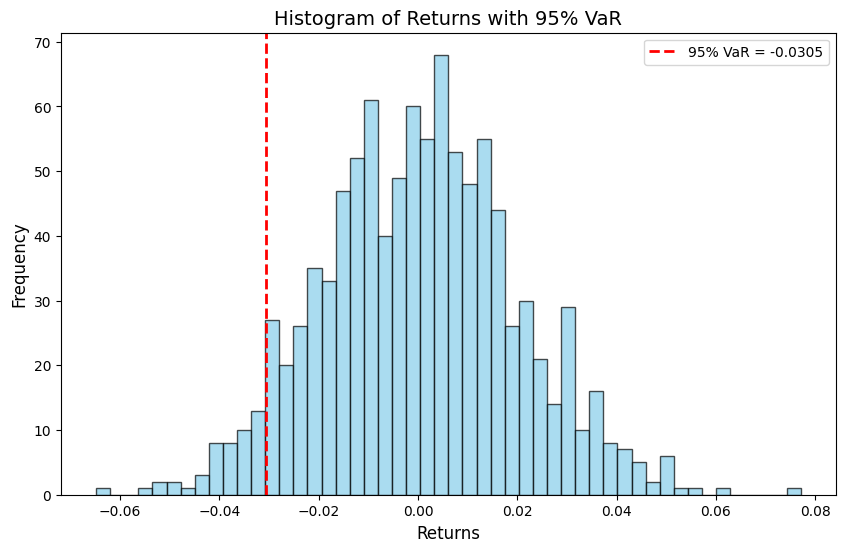

In [2]:
# Simulate some returns data (normally distributed for simplicity)
np.random.seed(42)  # For reproducibility
returns = np.random.normal(loc=0, scale=0.02, size=1000)  # mean 0, std 2%, 1000 data points

# Calculate the 95th percentile (VaR at 95% confidence level)
VaR_95 = np.percentile(returns, 5)

# Plot the histogram of returns
plt.figure(figsize=(10, 6))
plt.hist(returns, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# Add a vertical line at the 95th percentile VaR
plt.axvline(x=VaR_95, color='r', linestyle='--', linewidth=2, label=f'95% VaR = {VaR_95:.4f}')

# Add labels and title
plt.title('Histogram of Returns with 95% VaR', fontsize=14)
plt.xlabel('Returns', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# Show the plot
plt.show()


## Downloading data

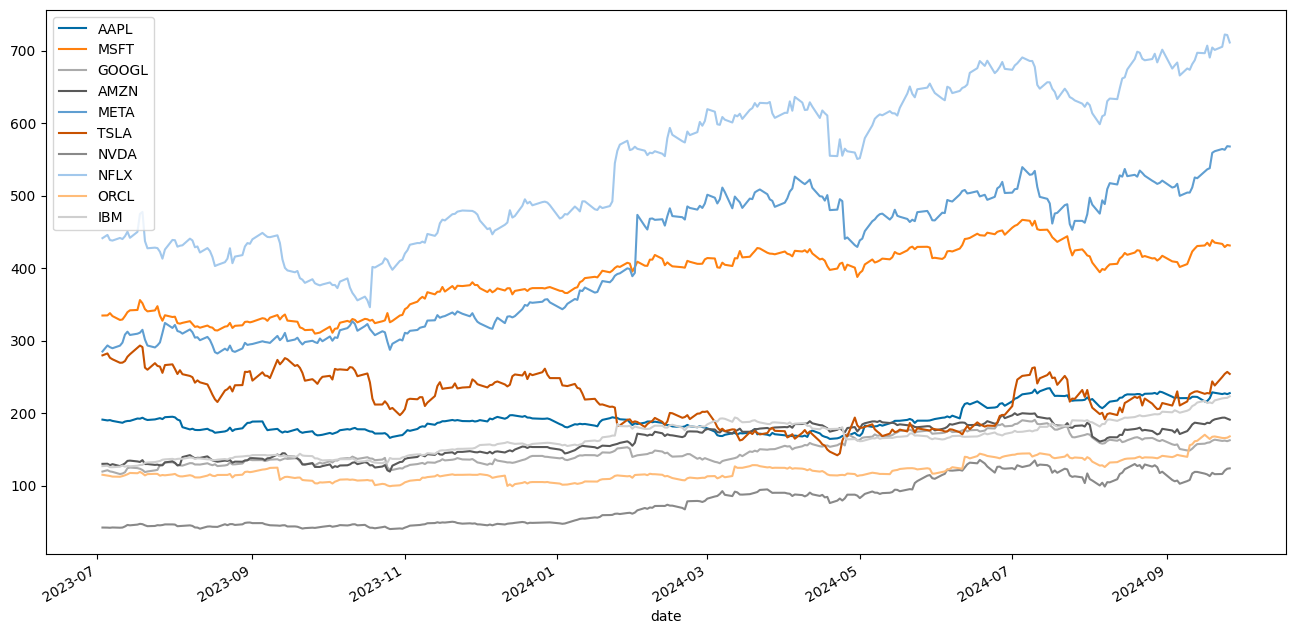

In [22]:
TICKERS = [
    "AAPL",
    "MSFT",
    "GOOGL",
    "AMZN",
    "META",
    "TSLA",
    "NVDA",
    "NFLX",
    "ORCL",
    "IBM",
]
START_DATE = "2023-07-01"

def get_adj_close_price(symbol, start_date):
    hist_price_url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start_date}&apikey={FMP_API_KEY}"
    r_json = requests.get(hist_price_url).json()
    df = pd.DataFrame(r_json["historical"]).set_index("date").sort_index()
    df.index = pd.to_datetime(df.index)
    return df[["adjClose"]].rename(columns={"adjClose": symbol})

price_df_list = []
for ticker in TICKERS:
    price_df_list.append(get_adj_close_price(ticker, START_DATE))
prices_df = price_df_list[0].join(price_df_list[1:])

prices_df.plot();

In [7]:
returns_df = prices_to_returns(prices_df)
returns_df

,AAPL,MSFT,GOOGL,AMZN,META,TSLA,NVDA,NFLX,ORCL,IBM
date,,,,,,,,,,
2023-07-05,-0.005857,0.000478,0.015468,0.001229,0.029212,0.009506,-0.002358,0.010103,-0.010159,0.004249
2023-07-06,0.002525,0.009226,-0.013503,-0.015493,-0.008109,-0.021028,-0.004965,-0.015833,-0.004386,-0.015434
2023-07-07,-0.005929,-0.011864,-0.005258,0.011063,-0.004981,-0.007630,0.009503,-0.001686,-0.007313,-0.000637
2023-07-10,-0.010821,-0.015988,-0.025340,-0.020419,0.012290,-0.017564,-0.007767,0.008240,-0.002041,0.006211
2023-07-11,-0.002828,0.001947,0.005940,0.012979,0.014221,0.000668,0.005455,-0.003396,0.007915,0.011553
...,...,...,...,...,...,...,...,...,...,...
2024-09-20,-0.002927,-0.007796,0.008943,0.009111,0.004024,-0.023245,-0.015865,-0.004671,0.002446,0.017813
2024-09-23,-0.007581,-0.004043,-0.010636,0.011900,0.005451,0.049318,0.002241,0.006191,-0.012202,0.012862
2024-09-24,0.003974,-0.010011,0.002719,0.000413,-0.001914,0.017080,0.039653,0.023945,-0.000904,0.002132


<Axes: title={'center': 'Cumulative Returns'}, xlabel='date'>

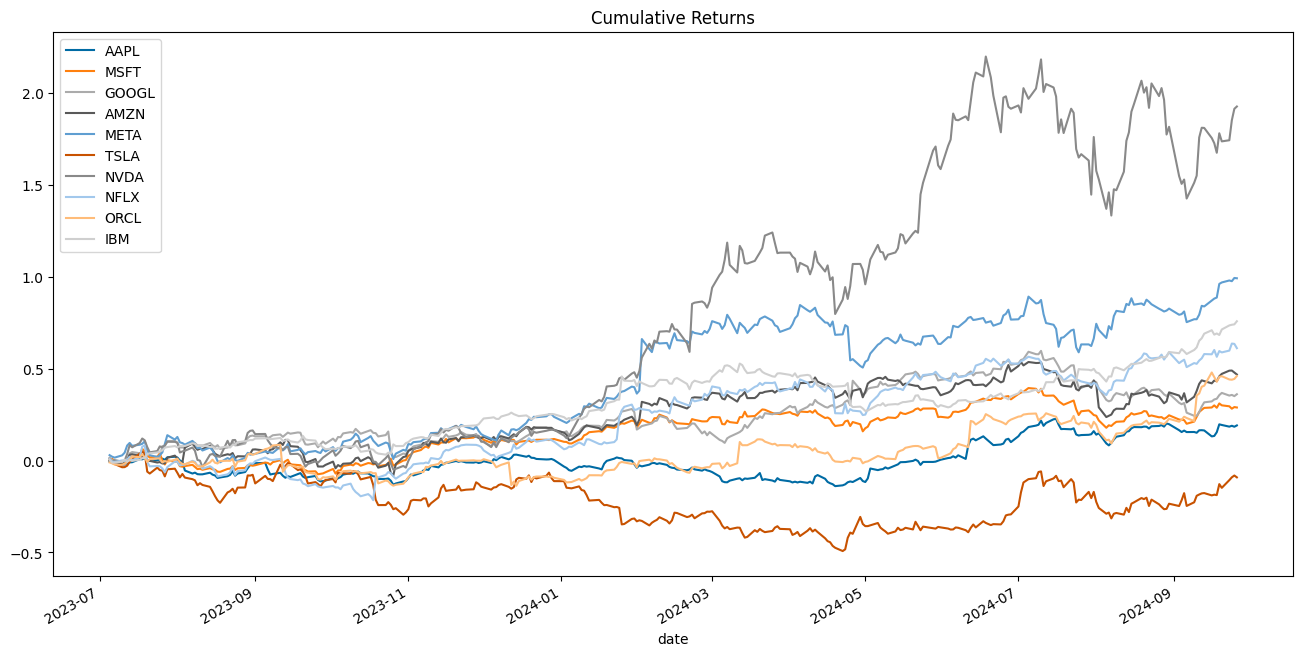

In [8]:
cumulative_returns_df = (1 + returns_df).cumprod() - 1
cumulative_returns_df.plot(title="Cumulative Returns")

In [9]:
X_train = returns_df.loc[:"2024-07-31"]
X_test = returns_df.loc["2024-08-01":]

## Portfolio Optimization

In [10]:
eq_w_model = EqualWeighted(
    portfolio_params=dict(name="Equally weighted"),
)
eq_w_model.fit(returns_df)

EqualWeighted(portfolio_params={'name': 'Equally weighted'})

In [11]:
max_ret_model = MeanRisk(
    objective_function=ObjectiveFunction.MAXIMIZE_RETURN,
    portfolio_params=dict(name="Max Return"),
)
max_ret_model.fit(returns_df)

MeanRisk(objective_function=MAXIMIZE_RETURN,
         portfolio_params={'name': 'Max Return'})

In [12]:
min_var_model = MeanRisk(
    objective_function=ObjectiveFunction.MINIMIZE_RISK,
    risk_measure=RiskMeasure.VARIANCE,
    portfolio_params=dict(name="Min Variance"),
)
min_var_model.fit(X_train)

MeanRisk(portfolio_params={'name': 'Min Variance'})

In [13]:
max_sharpe_model = MeanRisk(
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    risk_measure=RiskMeasure.VARIANCE,
    portfolio_params=dict(name="Max Sharpe"),
)
max_sharpe_model.fit(returns_df)

MeanRisk(objective_function=MAXIMIZE_RATIO,
         portfolio_params={'name': 'Max Sharpe'})

In [14]:
min_cvar_model = MeanRisk(
    risk_measure=RiskMeasure.CVAR,
    objective_function=ObjectiveFunction.MINIMIZE_RISK,
    portfolio_params=dict(name="Min CVaR"),
)
min_cvar_model.fit(X_train)

MeanRisk(portfolio_params={'name': 'Min CVaR'}, risk_measure=CVaR)

In [15]:
min_evar_model = MeanRisk(
    risk_measure=RiskMeasure.EVAR,
    objective_function=ObjectiveFunction.MINIMIZE_RISK,
    portfolio_params=dict(name="Min EVaR"),
)
min_evar_model.fit(X_train)

MeanRisk(portfolio_params={'name': 'Min EVaR'}, risk_measure=EVaR)

In [16]:
eq_w_train = eq_w_model.predict(X_train)
eq_w_test = eq_w_model.predict(X_test)

max_ret_train = max_ret_model.predict(X_train)
max_ret_test = max_ret_model.predict(X_test)

min_var_train = min_var_model.predict(X_train)
min_var_test = min_var_model.predict(X_test)

max_sharpe_train = max_sharpe_model.predict(X_train)
max_sharpe_test = max_sharpe_model.predict(X_test)

min_cvar_train = min_cvar_model.predict(X_train)
min_cvar_test = min_cvar_model.predict(X_test)

min_evar_train = min_evar_model.predict(X_train)
min_evar_test = min_evar_model.predict(X_test)

In [17]:
population_train = Population([eq_w_train, max_ret_train, min_var_train, max_sharpe_train, min_cvar_train, min_evar_train])
population_test = Population([eq_w_test, max_ret_test, min_var_test, max_sharpe_test, min_cvar_test, min_evar_test])
population_train.plot_composition()

In [18]:
population_train.plot_cumulative_returns()

In [19]:
population_test.plot_cumulative_returns()

In [20]:
population_train.summary()

,Equally weighted,Max Return,Min Variance,Max Sharpe,Min CVaR,Min EVaR
Mean,0.15%,0.42%,0.12%,0.21%,0.14%,0.12%
Annualized Mean,37.14%,105.77%,30.14%,52.00%,34.40%,31.20%
Variance,0.016%,0.091%,0.0082%,0.014%,0.0090%,0.0094%
Annualized Variance,3.98%,22.83%,2.06%,3.55%,2.27%,2.37%
Semi-Variance,0.0084%,0.040%,0.0043%,0.0068%,0.0045%,0.0048%
Annualized Semi-Variance,2.13%,10.15%,1.08%,1.72%,1.12%,1.20%
Standard Deviation,1.26%,3.01%,0.90%,1.19%,0.95%,0.97%
Annualized Standard Deviation,19.95%,47.78%,14.35%,18.84%,15.06%,15.39%
Semi-Deviation,0.92%,2.01%,0.66%,0.83%,0.67%,0.69%
Annualized Semi-Deviation,14.59%,31.86%,10.41%,13.12%,10.60%,10.97%


In [21]:
population_test.summary()

,Equally weighted,Max Return,Min Variance,Max Sharpe,Min CVaR,Min EVaR
Mean,0.23%,0.22%,0.21%,0.38%,0.28%,0.21%
Annualized Mean,58.83%,55.89%,53.58%,94.67%,71.79%,52.63%
Variance,0.025%,0.15%,0.010%,0.019%,0.011%,0.013%
Annualized Variance,6.30%,38.88%,2.59%,4.79%,2.72%,3.28%
Semi-Variance,0.015%,0.085%,0.0068%,0.010%,0.0069%,0.0084%
Annualized Semi-Variance,3.73%,21.38%,1.71%,2.64%,1.73%,2.13%
Standard Deviation,1.58%,3.93%,1.01%,1.38%,1.04%,1.14%
Annualized Standard Deviation,25.11%,62.36%,16.09%,21.90%,16.48%,18.12%
Semi-Deviation,1.22%,2.91%,0.82%,1.02%,0.83%,0.92%
Annualized Semi-Deviation,19.32%,46.24%,13.07%,16.26%,13.14%,14.59%
